In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from statsmodels.api import tsa
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def parse_quarter(string):
    """
    Converts a string from the format YYYYQN in datetime object at the end of quarter N.
    """
    
    # Note: you could also just retrieve the first four elements of the string
    # and the last one... Regex is fun but often not necessary
    year, qn = re.search(r'^(20[0-9][0-9])(Q[1-4])$', string).group(1, 2)
    
    # year and qn will be strings, pd.datetime expects integers.
    year = int(year)
    
    date = None
    
    if qn=='Q1':
        date = pd.datetime(year, 3, 31)
    elif qn=='Q2':
        date = pd.datetime(year, 6, 30)
    elif qn=='Q3':
        date = pd.datetime(year, 9, 20)
    else:
        date = pd.datetime(year, 12, 31)
        
    return date


alcohol_consumption = pd.read_csv('data/NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)

<ipython-input-2-4292bd9f59a7>:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = pd.datetime(year, 9, 20)
<ipython-input-2-4292bd9f59a7>:28: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = pd.datetime(year, 3, 31)
<ipython-input-2-4292bd9f59a7>:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = pd.datetime(year, 12, 31)
<ipython-input-2-4292bd9f59a7>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date = pd.datetime(year, 6, 30)


# Modelling and Forecasting Time Series
## Getting a stationary time series

In the previous notebook, you had seen that differencing with a lag of 4 made sense. 

Let's do that, does the resulting series look stationary?

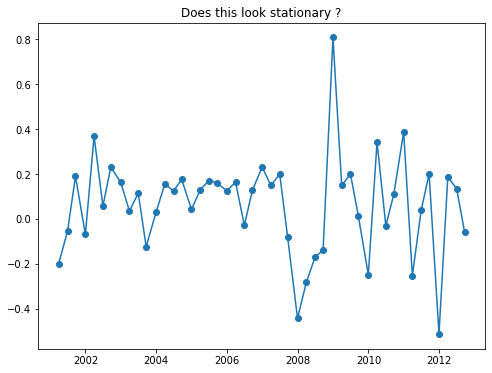

In [3]:
wine = alcohol_consumption.TotalWine
wine_diff = wine.diff(4).dropna()

plt.figure(figsize=(8, 6))
plt.plot(wine_diff, "-o")
plt.title("Does this look stationary ?");

It looks stationary enough. Let's call the result `time_series`.

In [4]:
time_series = wine_diff

## Autoregression model

In an autoregression model, values are modelled as a linear combination of the $p$ past values. An autoregressive model of order $p$, that is usually indicated as $AR(p)$ model, can be written as:

$$
y_{t} = c + (\phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p}) + e_{t},
$$

where

* `c` is the mean of the time-series
* `e_t` is the noise

The library `statsmodels` contains a `tsa` module which implements the autoregressive model.

**Task**:

* Define an `AR` model using `tsa.AR` 
* select the order using the `select_order` method. You will need to specify a maximum `p` to consider and a criterion for deciding which model is "best" 
  * AIC and BIC are common parameters which encourage "good fit" while penalising having too many parameters (complex model). 

In [5]:
#com+ add your code here


ModuleNotFoundError: No module named 'statsmodels'

### Having a look at the AR model

Let's see if the AR(p) does a good job compared to the original time series. 

* use the `fit` method specifying the optimal lag found above
* use the `predict` method to generate values starting at the optimal lag
* plot the predicted results and the data, how does it look?

In [ ]:
#com+ your code here 


As for the linear regression, we may want to look at the "size" of the residuals. For example you could display the Mean Absolute Error (MAE) using `mean_absolute_error` and feeding the original time series from `optlag` onwards and compare it with the prediction.

In [ ]:
#com+ add your code here to show the MAE


### Autoregression with Sklearn

Autoregression can also be implemented using `sklearn`. However, it doesn't provide direct support to handle time series, which means that you have to reorganise the data before estimating the model:

In [ ]:
def organize_data(to_forecast, window, horizon=1):
    """
     Input:
      to_forecast, univariate time series organised as numpy array
      window, number of observations to use in a forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y


X, y = organize_data(time_series, optlag)

We can now fit an autoregressive model which simply corresponds to a `LinearRegression` now:

In [ ]:
#com+ add your code here to fit a linear regression and show the results


The results are the same, yay!

***TIP***: Now that you know how to implement autoregression with sklearn, you're also able to create custom autoregressive models using other regressors implemented in sklearn.

## ARMA model

AR models a point in the time series as a linear model of the previous values. The mismatch $e_t$ is assumed to be "noise".
However there could still be information in the series of $e_t$! How about we add the past errors as additionnal features?

This leads to the **ARMA** model with an autoregressive part that you will recognise and a part that corresponds to a moving average:

$$
y_{t} = c + \underbrace{ \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} }_{AR(p)} + \underbrace{ \theta_{1}e_{t-1} + \theta_{2}e_{t-2} + \dots + \theta_{q}e_{t-q} }_{MA(q)} +e_{t},
$$

ARMA models are also implemented in `statsmodels` and their implementation is consistent with the one of AR models. 

* Create an ARMA model with `tsa.ARMA`, specify $p=3$ and $q=3$
* Fit and predict
* Display

Since the result will look almost identical to just using AR, you will want to show the MAE as well. 

In [ ]:
#com+ add your code here to fit an ARMA model


In [ ]:
#com+ add your code here to show the MAE
